In [1]:
#Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn import over_sampling, under_sampling
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
from google.colab import drive
drive.mount("Drive")

Drive already mounted at Drive; to attempt to forcibly remount, call drive.mount("Drive", force_remount=True).


In [4]:
train_transaction_data = pd.read_csv("Drive/MyDrive/job/Upskill/test/train_transaction.csv")
train_identity_data = pd.read_csv("Drive/MyDrive/job/Upskill/test/train_identity.csv")
test_transaction_data = pd.read_csv("Drive/MyDrive/job/Upskill/test/test_transaction.csv")
test_identity_data = pd.read_csv("Drive/MyDrive/job/Upskill/test/test_identity.csv")

In [5]:
sample_submission = pd.read_csv("Drive/MyDrive/job/Upskill/test/sample_submission.csv")

In [6]:
train_data = train_transaction_data.merge(train_identity_data, how="left", on="TransactionID")
test_data = test_transaction_data.merge(test_identity_data, how="left", on="TransactionID")

del train_transaction_data, train_identity_data, test_transaction_data, test_identity_data

In [7]:
test_data.rename({'id-01':'id_01','id-02':'id_02','id-03':'id_03','id-04':'id_04','id-05':'id_05','id-06':'id_06','id-07':'id_07','id-08':'id_08','id-09':'id_09','id-10':'id_10','id-11':'id_11','id-12':'id_12','id-13':'id_13','id-14':'id_14','id-15':'id_15','id-16':'id_16','id-17':'id_17','id-18':'id_18','id-19':'id_19','id-20':'id_20','id-21':'id_21','id-22':'id_22','id-23':'id_23','id-24':'id_24','id-25':'id_25','id-26':'id_26','id-27':'id_27','id-28':'id_28','id-29':'id_29','id-30':'id_30','id-31':'id_31', 'id-32':'id_32', 'id-33':'id_33', 'id-34':'id_34', 'id-35':'id_35', 'id-36':'id_36', 'id-37':'id_37', 'id-38':'id_38'}, axis=1, inplace=True)

In [8]:
print(train_data.info())
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 506691 entries, 0 to 506690
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(3), object(31)
memory usage: 1.6+ GB
None


In [9]:
def getnulls(data): 
 total = data.isnull().sum().sort_values(ascending=False) 
 percent = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)
 missing_data = pd.concat([total, percent], axis=1, keys=['total', 'percent']) 
 return missing_data 
missing_data_train = getnulls(train_data) 
#missing_data_train.head()
print(missing_data_train)

                total   percent
id_24          585793  0.991962
id_25          585408  0.991310
id_07          585385  0.991271
id_08          585385  0.991271
id_21          585381  0.991264
...               ...       ...
C11                 0  0.000000
C12                 0  0.000000
C13                 0  0.000000
C14                 0  0.000000
TransactionID       0  0.000000

[434 rows x 2 columns]


In [10]:
print(missing_data_train.index)

Index(['id_24', 'id_25', 'id_07', 'id_08', 'id_21', 'id_26', 'id_22', 'id_23',
       'id_27', 'dist2',
       ...
       'C5', 'C6', 'C7', 'C8', 'C10', 'C11', 'C12', 'C13', 'C14',
       'TransactionID'],
      dtype='object', length=434)


In [11]:
print(len(train_data["id_24"].isnull()))

590540


In [12]:
#correlation

corr = abs(train_data[train_data.columns[1:]].corr()["isFraud"][:-1]).sort_values(ascending = False)
print(corr)

isFraud    1.000000
V257       0.383060
V246       0.366878
V244       0.364129
V242       0.360590
             ...   
V299       0.000308
V135       0.000276
V137       0.000115
V319       0.000061
V136       0.000042
Name: isFraud, Length: 401, dtype: float64


In [13]:
print(len(train_data[train_data["isFraud"] == 1]) / len(train_data[train_data["isFraud"] == 0]), len(train_data[train_data["isFraud"] == 1]), len(train_data[train_data["isFraud"] == 0]))

0.03625870143908247 20663 569877


In [14]:
print(train_data[train_data["isFraud"] == 1].isnull().sum().sort_values(ascending = False))
print(train_data[train_data["isFraud"] == 0].isnull().sum().sort_values(ascending = False))
print((train_data[train_data["isFraud"] == 1].isnull().sum() / train_data[train_data["isFraud"] == 0].isnull().sum()).sort_values(ascending = False))

train_data_fraud_count = train_data[train_data["isFraud"] == 1].isnull().sum().sort_values(ascending = False) / train_data[train_data["isFraud"] == 0].isnull().sum()
train_data_fraud_count = train_data_fraud_count.sort_values(ascending=False)

id_24            20261
id_25            20246
id_26            20238
id_08            20237
id_21            20237
                 ...  
C11                  0
C12                  0
C13                  0
C14                  0
TransactionID        0
Length: 434, dtype: int64
id_24            565532
id_25            565162
id_07            565148
id_08            565148
id_21            565144
                  ...  
C11                   0
C12                   0
C13                   0
C14                   0
TransactionID         0
Length: 434, dtype: int64
V316    0.2
V293    0.2
V295    0.2
V297    0.2
V298    0.2
       ... 
C10     NaN
C11     NaN
C12     NaN
C13     NaN
C14     NaN
Length: 434, dtype: float64


In [15]:
dropped_cols = []
for index, row in missing_data_train.iterrows():
    try:

        if((row["percent"] > .3 and train_data_fraud_count[index] >= 0.025 and train_data_fraud_count[index] <= .045) or corr[index] < 0.02):
            dropped_cols.append(index)
    
    except:
        if((row["percent"] > .3 and train_data_fraud_count[index] >= 0.025 and train_data_fraud_count[index] <= .045)):
            dropped_cols.append(index)

In [16]:
print(dropped_cols)
print(len(dropped_cols))

['id_24', 'id_25', 'id_07', 'id_08', 'id_21', 'id_26', 'id_22', 'id_23', 'id_27', 'dist2', 'D7', 'id_18', 'D13', 'D14', 'D12', 'id_04', 'id_03', 'D6', 'id_33', 'id_10', 'D8', 'D9', 'id_09', 'id_30', 'id_32', 'id_34', 'id_14', 'V149', 'V153', 'V156', 'V154', 'V155', 'V157', 'V158', 'V161', 'V163', 'V147', 'V148', 'V162', 'V146', 'V138', 'V139', 'V140', 'V141', 'V142', 'V166', 'V164', 'V160', 'V159', 'V143', 'V144', 'V145', 'V152', 'V151', 'V150', 'V165', 'V339', 'V322', 'V338', 'V337', 'V336', 'V335', 'V334', 'V333', 'V332', 'V331', 'V330', 'V329', 'V328', 'V327', 'V326', 'V325', 'V324', 'V323', 'DeviceInfo', 'id_13', 'V267', 'V266', 'V265', 'V264', 'V263', 'V269', 'V253', 'V241', 'V240', 'V268', 'V226', 'V278', 'V223', 'V224', 'V277', 'V275', 'V274', 'V273', 'V225', 'V276', 'id_05', 'V202', 'V207', 'V203', 'V214', 'V211', 'V215', 'V216', 'V168', 'V206', 'V182', 'V183', 'V178', 'V177', 'V167', 'V179', 'V205', 'V192', 'V172', 'V174', 'V175', 'V180', 'V208', 'V209', 'V210', 'id_11', 'V270

In [17]:
train_data.drop(dropped_cols, axis =  1, inplace = True)
test_data.drop(dropped_cols, axis =  1, inplace = True)

In [18]:
print(train_data.shape)
print(test_data.shape)

(590540, 234)
(506691, 233)


In [19]:
#correlation among features

feature_correlation = train_data.corr()

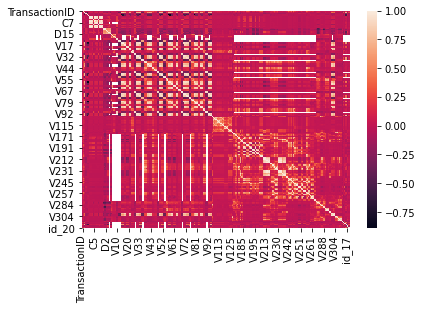

In [20]:
sns.heatmap(feature_correlation)

In [ ]:
feature_correlation.to_excel("feature_correlation.xlsx")

In [ ]:
train_data[0:1000].to_excel("Cleaned_train_data.xlsx")

In [21]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 234 entries, TransactionID to DeviceType
dtypes: float64(208), int64(2), object(24)
memory usage: 1.0+ GB


In [22]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506691 entries, 0 to 506690
Columns: 233 entries, TransactionID to DeviceType
dtypes: float64(208), int64(1), object(24)
memory usage: 904.6+ MB


In [23]:
# Select categorical columns
categorical_cols = [cname for cname in test_data.columns if
                   test_data[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in test_data.columns if 
                  test_data[cname].dtype != "object"]

In [24]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median', fill_value="missing")), ('scale', StandardScaler())])

# Preprocessing for categorical data (onehot)
categorical_transformer_onehot = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('onehot', OneHotEncoder(dtype = np.int8, handle_unknown='ignore'))])

# Preprocessing for categorical data (labelencoder)
categorical_transformer_ordinal = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('ordinal', OrdinalEncoder(dtype = np.int8))])

# Bundle preprocessing for numerical and categorical data
preprocessor_onehot = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer_onehot, categorical_cols)
    ])

preprocessor_label = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer_ordinal, categorical_cols)
    ])

In [25]:
#separating train data and target

Y = train_data['isFraud'].copy()
train_data.drop('isFraud', axis=1, inplace = True)

print(train_data)
print(Y)

        TransactionID ProductCD  card3  ... id_37  id_38 DeviceType
0             2987000         W  150.0  ...   NaN    NaN        NaN
1             2987001         W  150.0  ...   NaN    NaN        NaN
2             2987002         W  150.0  ...   NaN    NaN        NaN
3             2987003         W  150.0  ...   NaN    NaN        NaN
4             2987004         H  150.0  ...     T      T     mobile
...               ...       ...    ...  ...   ...    ...        ...
590535        3577535         W  150.0  ...   NaN    NaN        NaN
590536        3577536         W  150.0  ...   NaN    NaN        NaN
590537        3577537         W  150.0  ...   NaN    NaN        NaN
590538        3577538         W  150.0  ...   NaN    NaN        NaN
590539        3577539         W  150.0  ...   NaN    NaN        NaN

[590540 rows x 233 columns]
0         0
1         0
2         0
3         0
4         0
         ..
590535    0
590536    0
590537    0
590538    0
590539    0
Name: isFraud, Length: 

In [26]:
X_train, X_val, Y_train, Y_val = train_test_split(train_data, Y, test_size=0.2, train_size=0.8, random_state=0)
X_train = preprocessor_label.fit_transform(X_train)
X_val = preprocessor_label.fit_transform(X_val)


In [ ]:
del train_data, Y

In [27]:
print(X_train.shape)

(472432, 233)


In [28]:
oversampling = over_sampling.RandomOverSampler(sampling_strategy=0.1)

steps = [('o', oversampling)]

pipeline = Pipeline(steps=steps)
X_train_oversample, Y_train_oversample = pipeline.fit_resample(X_train, Y_train.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [29]:
model = XGBClassifier(n_estimators=200,
    max_depth=50,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-999,
    random_state=2020)
model.fit(X_train, Y_train, verbose=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=50,
              min_child_weight=1, missing=-999, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=2020,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

In [ ]:
del X_train,Y_train

In [30]:
predict = model.predict(X_val)

In [31]:
print(f1_score(predict, Y_val))
print(roc_auc_score(predict, Y_val))
print(accuracy_score(predict, Y_val))

0.7124689826302729
0.9717570844821568
0.9843025027940528


In [32]:
X_test = preprocessor_label.fit_transform(test_data)

In [33]:
test_predict = model.predict_proba(X_test)

In [34]:
submission = pd.DataFrame({
    'TransactionID' : sample_submission.TransactionID,
    'isFraud' : test_predict[:,1]
})
submission.head()

,TransactionID,isFraud
0,3663549,0.001268
1,3663550,0.002332
2,3663551,0.052699
3,3663552,0.002623
4,3663553,0.000761


In [35]:
submission.to_csv("Drive/MyDrive/job/Upskill/test/submission_tree_7.csv", index = False)

In [ ]:
model = XGBClassifier(n_estimators=900,
    max_depth=10,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-999,
    random_state=2020)
model.fit(X_train_oversample, Y_train_oversample)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=-999, n_estimators=900, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=2020,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

In [ ]:
predict = model.predict(X_val)

In [ ]:
print(f1_score(predict, Y_val))
print(roc_auc_score(predict, Y_val))
print(accuracy_score(predict, Y_val))

0.7175885279484929
0.933753293713705
0.9836590239441867


In [ ]:
X_test = preprocessor_label.fit_transform(test_data)

In [ ]:
test_predict = model.predict_proba(X_test)

In [ ]:
submission_2 = pd.DataFrame({
    'TransactionID' : sample_submission.TransactionID,
    'isFraud' : test_predict[:,1]
})
submission_2.head()

,TransactionID,isFraud
0,3663549,0.000857
1,3663550,0.001187
2,3663551,0.013556
3,3663552,0.001123
4,3663553,0.000230


In [ ]:
submission_2.to_csv("Drive/MyDrive/job/Upskill/test/submission_tree_6.csv", index = False)